In [1]:
from flaxdiff.schedulers import EDMNoiseScheduler, KarrasVENoiseScheduler
from flaxdiff.predictors import KarrasPredictionTransform
from flaxdiff.models.simple_unet import Unet
from flaxdiff.trainer import DiffusionTrainer
from flaxdiff.data.datasets import get_dataset_grain
from flaxdiff.utils import defaultTextEncodeModel
from flaxdiff.samplers.euler import EulerAncestralSampler
import jax
import jax.numpy as jnp
import optax
from datetime import datetime

BATCH_SIZE = 16
IMAGE_SIZE = 128

/home/mrwhite0racle/miniconda3/envs/mlops/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt

normalizeImage = lambda x: jax.nn.standardize(x, mean=[127.5], std=[127.5])
denormalizeImage = lambda x: (x + 1.0) * 127.5


def plotImages(imgs, fig_size=(8, 8), dpi=100):
    fig = plt.figure(figsize=fig_size, dpi=dpi)
    imglen = imgs.shape[0]
    for i in range(imglen):
        plt.subplot(fig_size[0], fig_size[1], i + 1)
        plt.imshow(jnp.astype(denormalizeImage(imgs[i, :, :, :]), jnp.uint8))
        plt.axis("off")
    plt.show()


In [3]:
text_encoder = defaultTextEncodeModel()

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing FlaxCLIPTextModel: {('vision_model', 'encoder', 'layers', '15', 'mlp', 'fc2', 'kernel'), ('vision_model', 'encoder', 'layers', '11', 'layer_norm2', 'bias'), ('vision_model', 'encoder', 'layers', '11', 'self_attn', 'q_proj', 'bias'), ('vision_model', 'encoder', 'layers', '6', 'mlp', 'fc2', 'kernel'), ('vision_model', 'encoder', 'layers', '14', 'mlp', 'fc2', 'bias'), ('vision_model', 'encoder', 'layers', '5', 'self_attn', 'q_proj', 'kernel'), ('vision_model', 'encoder', 'layers', '17', 'self_attn', 'q_proj', 'bias'), ('vision_model', 'encoder', 'layers', '12', 'self_attn', 'k_proj', 'kernel'), ('vision_model', 'encoder', 'layers', '15', 'self_attn', 'k_proj', 'kernel'), ('vision_model', 'encoder', 'layers', '0', 'mlp', 'fc2', 'kernel'), ('vision_model', 'encoder', 'layers', '0', 'layer_norm1', 'bias'), ('vision_model', 'encoder', 'layers', '14', 'self_attn', 'out_proj', 'kernel'), ('visi

In [4]:
# Define noise scheduler
edm_schedule = EDMNoiseScheduler(1, sigma_max=80, rho=7, sigma_data=0.5)
karas_ve_schedule = KarrasVENoiseScheduler(1, sigma_max=80, rho=7, sigma_data=0.5)
# Define model

input_shapes = {
    "x": (IMAGE_SIZE, IMAGE_SIZE, 3),
    "temb": (),
    "textcontext": (77, 768)
}

unet = Unet(emb_features=256, 
            feature_depths=[64, 64, 128, 256, 512],
            attention_configs=[
                None,
                {"heads":8, "dtype":jnp.float32, "flash_attention":False, "use_projection":False, "use_self_and_cross":True}, 
                {"heads":8, "dtype":jnp.float32, "flash_attention":False, "use_projection":False, "use_self_and_cross":True}, 
                {"heads":8, "dtype":jnp.float32, "flash_attention":False, "use_projection":False, "use_self_and_cross":True}, 
                {"heads":8, "dtype":jnp.float32, "flash_attention":False, "use_projection":False, "use_self_and_cross":False}
            ],
            num_res_blocks=2,
            num_middle_res_blocks=1
)

In [5]:
!pwd

/home/mrwhite0racle/miniconda3/envs/mlops/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


/home/mrwhite0racle/mlops-diffusion-project


In [7]:
# Define optimizer
solver = optax.adam(2e-4)
name = "prototype-edm-Diffusion_SDE_VE_" + datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

checkpoint_path = '/home/mrwhite0racle/mlops-diffusion-project/prototype-checkpoint/diffusion_sde_ve_2025-04-08_16:00:25'

# Create trainer
trainer = DiffusionTrainer(
    unet, optimizer=solver, 
    input_shapes=input_shapes,
    noise_schedule=edm_schedule,
    rngs=jax.random.PRNGKey(4), 
    name=name,
    model_output_transform=KarrasPredictionTransform(sigma_data=edm_schedule.sigma_data),
    encoder=text_encoder,
    distributed_training=True,
    wandb_config=None,
    load_from_checkpoint=checkpoint_path
)


Loading model from checkpoint at step  215642
Loaded model from checkpoint at epoch 421 step 215642 0.06535565
Generating states for DiffusionTrainer


In [7]:
null_labels_full = text_encoder([""])

In [8]:
sampler = EulerAncestralSampler(trainer.model, None, noise_schedule=karas_ve_schedule, 
                                image_size=IMAGE_SIZE,
                                autoencoder=trainer.autoencoder,
                                model_output_transform=trainer.model_output_transform, 
                                guidance_scale=4, null_labels_seq=null_labels_full)


Using classifier-free guidance


100%|██████████| 200/200 [00:26<00:00,  7.59it/s]


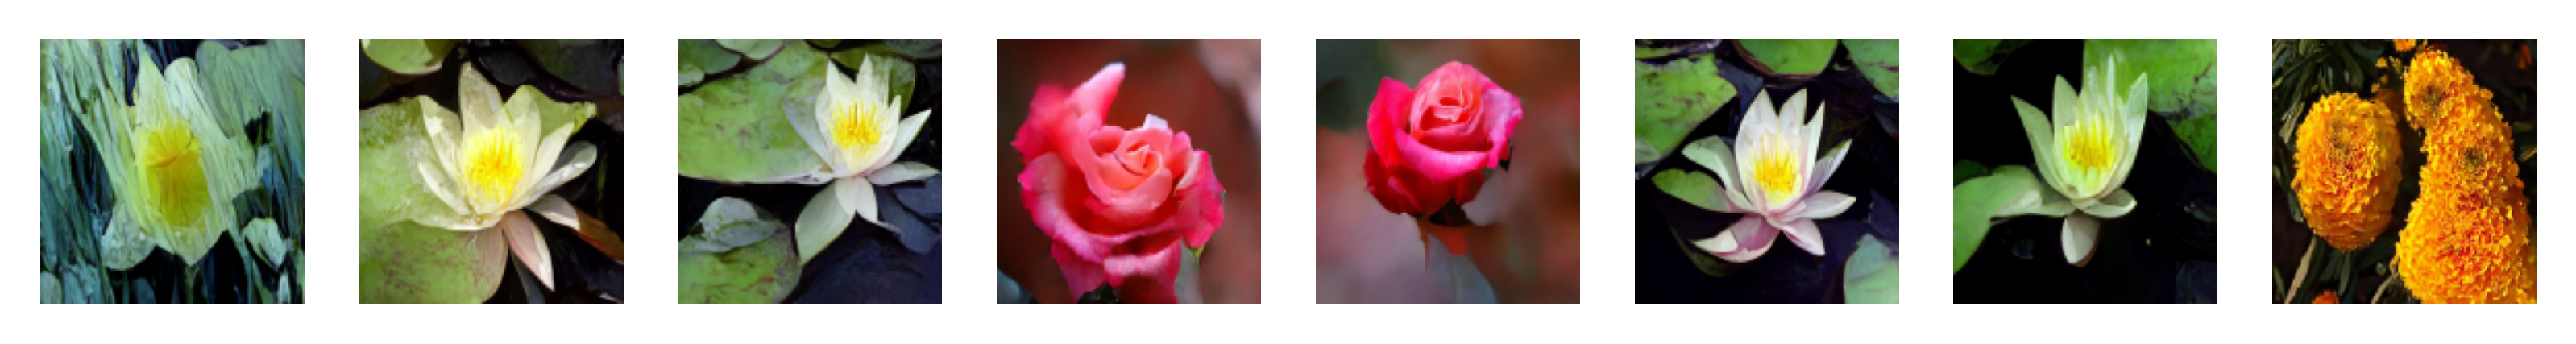

In [10]:
prompts = [
    'water tulip', 
    'a water lily', 
    'a water lily',
    'a photo of a rose', 
    'a photo of a rose', 
    'a water lily', 
    'a water lily', 
    'a photo of a marigold', 
]

samples = sampler.generate_images(
    params=trainer.get_state().ema_params, 
    num_images=len(prompts), 
    diffusion_steps=200, 
    start_step=1000, 
    end_step=0, 
    priors=None, 
    model_conditioning_inputs=(text_encoder(prompts),))
plotImages(samples, dpi=500)

In [ ]:
"""
TODO: Put this model on wandb model registry
entity - umd-projects
project - mlops-msml605-project
registry - mlops-diffusion-oxfordflowers
collection - prototypes
"""

import wandb
import random

# Initialize a W&B run to track the artifact
run = wandb.init(
    project="mlops-msml605-project",
    entity="umd-projects",
    name=name,
    tags=["diffusion", "flaxdiff", "flax", "jax"],
    job_type="train",
    config={
        "model": "Diffusion SDE VE",
        "dataset": "Oxford Flowers",
        "optimizer": "adam",
        "learning_rate": 2e-4,
        "batch_size": BATCH_SIZE,
        "image_size": IMAGE_SIZE
    }
)
    
# Log the artifact to W&B
logged_artifact = run.log_artifact(
    artifact_or_path=checkpoint_path,
    name='model',
    type="model"
)

run.link_artifact(   
  artifact=logged_artifact,  
  target_path="umd-projects-org/wandb-registry-model/diffusion-experimental-oxford"
)

wandb: Adding directory to artifact (/home/mrwhite0racle/mlops-diffusion-project/prototype-checkpoint/diffusion_sde_ve_2025-04-08_16:00:25)... Done. 33.7s
wandb: ERROR LinkArtifact: prototypes, error: returned error 400: {"data":{"linkArtifact":null},"errors":[{"message":"cannot link artifact of type `model` to collection of type `Model`","path":["linkArtifact"]}]}


In [22]:
run.finish()

wandb: ERROR The nbformat package was not found. It is required to save notebook history.
